In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# **Ques 1**: Variants of Backprop for visualizing CNNs

In [ ]:
#Downloading a ResNet-50 trained on the ILSVRC classification task
import torch
model = torch.hub.load('pytorch/vision', 'resnet50', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_main


In [ ]:
# setting the folder ID
folder_id = '1vJYMsun8wQghcxeQbuGPwVboxGdT0f-n'

In [ ]:
# getting a list of all the files in the folder
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

In [ ]:
#The downloaded files will be stored in the current working directory of the Colab notebook
files = []
for file in file_list:
    file.GetContentFile(file['title'])
    files.append(file['title'])

# creating a table of the file names
# df = pd.DataFrame({'file_name': files})
# display(df)
img_list = ['i1.jpg','i2.jpg','i3.jpg','i4.jpg','i5.jpg']

i1.jpg


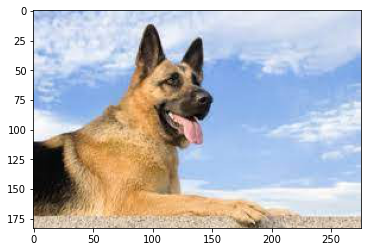

i2.jpg


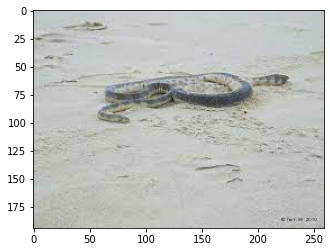

i3.jpg


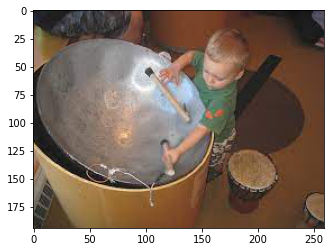

i4.jpg


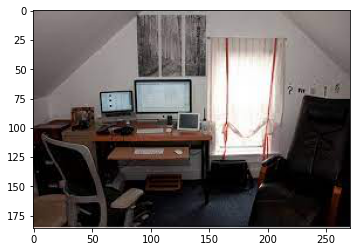

i5.jpg


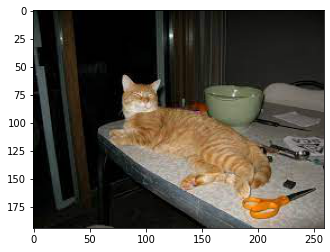

In [ ]:
#Viewing the images
import matplotlib.image as mpimg
for i in range(len(img_list)):
  print(img_list[i])
  img = mpimg.imread(img_list[i])
  # print(img.shape)
  plt.imshow(img)
  plt.show()

Now, Considering the neuron corresponding to the highest predicted score in the output layer, let's implement and visualize the results for different techniques mentioned in the question

**Ques 1.a)Vanilla Backpropagation**

In [ ]:
#setting the Resnet-50 model to evaluation mode
model.eval()

In [ ]:
#Load the 5 images and preprocess them using the same transformations as those used during training
from torchvision import transforms
from PIL import Image
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img_tensors = []
for img_file in img_list:
    img = Image.open(img_file)
    img_tensor = transform(img)
    img_tensor.requires_grad_(True)
    # img_tensor = img_tensor.unsqueeze(0) # Add batch dimension
    print(img_tensor.shape)
    # img_tensor = img_tensor.requires_grad_()
    img_tensors.append(img_tensor)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Visualizing Vanilla Backpropagation result for image i1.jpg:


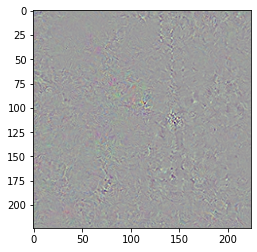


Visualizing Vanilla Backpropagation result for image i2.jpg:


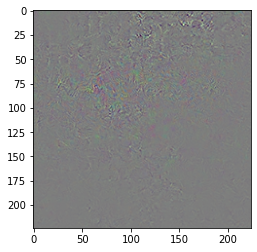


Visualizing Vanilla Backpropagation result for image i3.jpg:


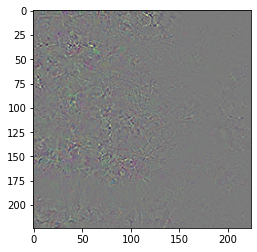


Visualizing Vanilla Backpropagation result for image i4.jpg:


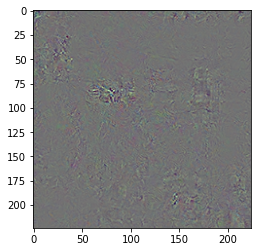


Visualizing Vanilla Backpropagation result for image i5.jpg:


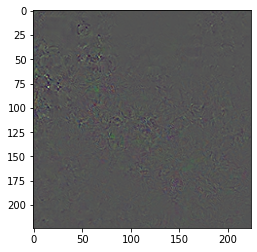

In [ ]:
# Performing a forward pass through the model for each image to obtain the output scores

# outputs = []
grads=[]
for i in range(0,len(img_tensors)):
    # print(img_tensor)
    img_tensor = img_tensors[i]
    output = model(img_tensor.unsqueeze(0))  # Adding batch dimension

    #Computing the gradient of the output neuron with the highest predicted score
    #w.r.t the input image using PyTorch's autograd functionality for each image
    index = output.argmax()
    output[:, index].backward()
    grad = img_tensor.grad
    grads.append(grad)



#Visualizing the gradients as images
for i in range(len(grads)):
    # print(grads[i])
    print(f'Visualizing Vanilla Backpropagation result for image i{i+1}.jpg:')
    grad = grads[i].squeeze().detach().numpy()
    grad = (grad - grad.min()) / (grad.max() - grad.min()) #normalizing
    plt.imshow(np.transpose(grad, (1, 2, 0)))
    plt.show()
    print()

**Ques 1(b) Guided-back-propagation**

In [ ]:
def reLU_backward(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):                    # for checking for ReLU child
        return (torch.clamp(grad_in[0], min = 0.),)

def captureHook(model):
    for c in model.children():
        if isinstance(c, torch.nn.ReLU):
            c.register_backward_hook(reLU_backward)
        else:
            captureHook(c)

In [ ]:
def guidedBackpropagation(image_tensor, model):
    captureHook(model)

    prediction = model(image_tensor.unsqueeze(0))              # Adding batch dimension
    index = prediction.argmax()

    prediction[:, index].backward()

    grad = image_tensor.grad
    return grad

Visualizing Guided Backpropagation result for image i1.jpg: 


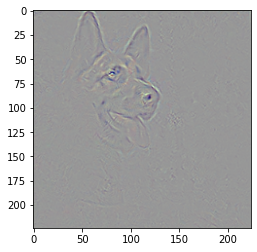


Visualizing Guided Backpropagation result for image i2.jpg: 


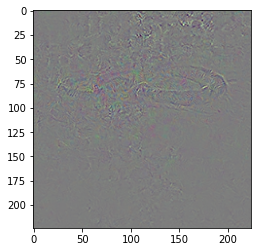


Visualizing Guided Backpropagation result for image i3.jpg: 


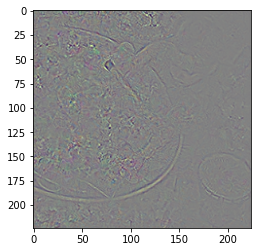


Visualizing Guided Backpropagation result for image i4.jpg: 


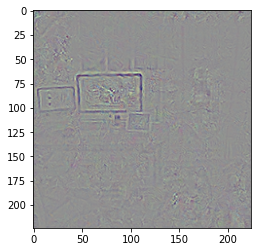


Visualizing Guided Backpropagation result for image i5.jpg: 


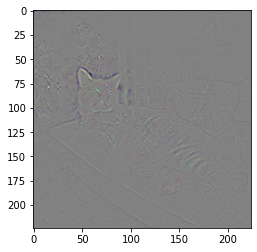

In [ ]:
grads = [guidedBackpropagation(img_tensors[i], model) for i in range(5)]
# print(len(grads))

#Visualizing the gradients as images
for i in range(len(grads)):
    # print(grads[i])
    print(f'Visualizing Guided Backpropagation result for image i{i+1}.jpg: ')
    grad = grads[i].squeeze().detach().numpy()
    grad = (grad - grad.min()) / (grad.max() - grad.min()) #normalizing
    plt.imshow(np.transpose(grad, (1, 2, 0)))
    plt.show()
    print()


**Ques 1(c) Class Activation Map (CAM)**

In [ ]:
def get_activation(model, layer_name):
    def hook(model, input, output):
        model.feature_map = output.detach()
    layer = model._modules.get(layer_name)
    layer.register_forward_hook(hook)
    return layer



Visualizing CAM result for image i1.jpg:


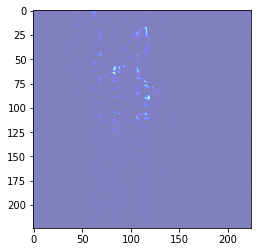


Visualizing CAM result for image i2.jpg:


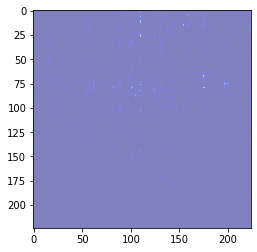


Visualizing CAM result for image i3.jpg:


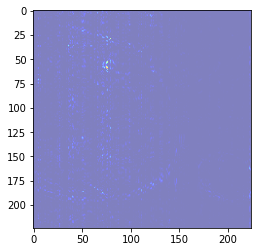


Visualizing CAM result for image i4.jpg:


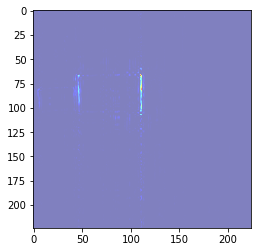


Visualizing CAM result for image i5.jpg:


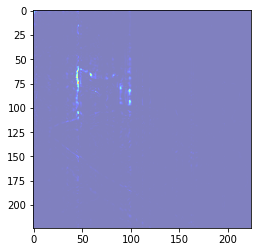

In [ ]:
grads=[]
for i in range(0,len(img_tensors)):
    last_conv_layer = get_activation(model, 'layer4')
    img_tensor = img_tensors[i]
    img_tensor.requires_grad_(True)  # Set requires_grad to True

    output = model(img_tensor.unsqueeze(0))  # Adding batch dimension


    index = output.argmax()
    output[:, index].backward()
    grad = img_tensor.grad.detach().cpu().numpy()  # Get the gradient
    # grads.append(grad)
    img_tensor.requires_grad_(False)  # Set requires_grad back to False to avoid accumulation

    cams = np.zeros_like(grad)  # Initialize cams with the same shape as grad
    weights = np.mean(grad, axis=(0,1))
    cam = np.sum(weights * grad, axis=0)

    cam = np.maximum(cam, 0)  # ReLU
    # cam = cam / np.max(cam)  # Normalize
    # print(cam)
    grads.append(cam)


# Visualizing the Class Activation Maps
for i in range(len(grads)):
    print(f'Visualizing CAM result for image i{i+1}.jpg:')
    grad = grads[i].squeeze()
    grad = (grad - grad.min()) / (grad.max() - grad.min()) #normalizing
    # plt.imshow(np.transpose(grad, (1, 2, 0)))
    plt.imshow(grad, alpha=0.5, cmap='jet')
    plt.show()
    print()


**Ques 1(d) Guided Grad-CAM**

In [ ]:
model.eval()

In [ ]:
# Global lists to capture activation and gradient values
activation_list, gradient_list = [], []

def forward_hook_grad(module, input, output):  #to capture activation values from ReLU layers
    if isinstance(module, torch.nn.ReLU):
        global activation_list
        activation_list.append(output)

def backward_hook_grad(module, grad_in,grad_out):      #to capture gradient values from ReLU layers
    if isinstance(module, torch.nn.ReLU):
        global gradient_list
        gradient_list.append(grad_in[0])

def guided_grad_cam(img_tensor, model):

    global activation_list, gradient_list

    # Registering the forward and backward hooks on the ReLU layer of the last convolutional block
    forward_handle =  model.layer4[-1].relu.register_forward_hook(forward_hook_grad)
    backward_handle = model.layer4[-1].relu.register_backward_hook(backward_hook_grad)

    # Getting the model's prediction
    prediction = model(img_tensor.unsqueeze(0))
    index = prediction.argmax()

    # Compute the gradient of the prediction w.r.t the activations of the last convolutional block
    prediction[:, index].backward()

    # Removing the hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute the Grad-CAM heatmap
    required_weights = gradient_list[0].mean((2,3), True)
    required_activation = activation_list[-1]*required_weights
    grad_cam = required_activation.sum(axis=1)
    grad_cam = torch.relu(grad_cam)

    # Resizing the heatmap to the size of the input image and normalizing it
    grad_cam = torch.nn.functional.interpolate(grad_cam.unsqueeze(0), size=(224,224), mode='bilinear')
    grad_cam = grad_cam[0,0].detach().numpy()
    grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min()) #normalizing grad cam

    # Combining the guided backpropagation and Grad-CAM to produce the guided Grad-CAM heatmap
    guided_back = guidedBackpropagation(img_tensor, model)

    guidedGradCAM = np.multiply(guided_back, grad_cam)
    guidedGradCAM = (guidedGradCAM - guidedGradCAM.min()) / (guidedGradCAM.max() - guidedGradCAM.min()) #normalizing guided grad cam
    return guidedGradCAM

Visualizing Guided Grad-CAM result for image i1.jpg: 


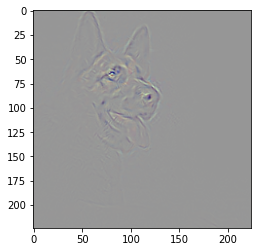


Visualizing Guided Grad-CAM result for image i2.jpg: 


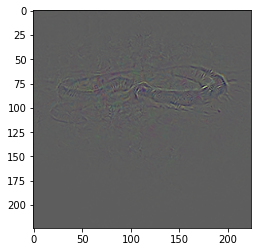


Visualizing Guided Grad-CAM result for image i3.jpg: 


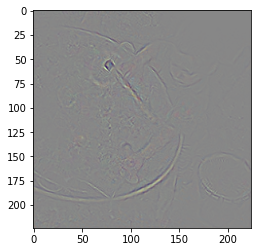


Visualizing Guided Grad-CAM result for image i4.jpg: 


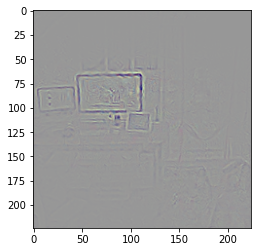


Visualizing Guided Grad-CAM result for image i5.jpg: 


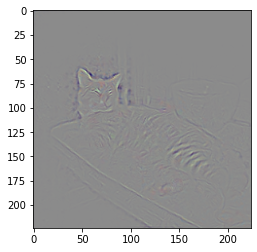

In [ ]:
grads = [guided_grad_cam(img_tensors[i], model) for i in range(5)]
# print(len(grads))

#Visualizing the gradients as images
for i in range(len(grads)):
    # print(grads[i])
    print(f'Visualizing Guided Grad-CAM result for image i{i+1}.jpg: ')
    grad = grads[i].squeeze().detach().numpy()
    grad = (grad - grad.min()) / (grad.max() - grad.min()) #normalizing
    plt.imshow(np.transpose(grad, (1, 2, 0)))
    plt.show()
    print()

# **Ques 2**: SGD Update rule variations

Defining the update rules to be implemented

In [ ]:
def vanilla_sgd(x, gradient, lr):
    return x - lr * gradient

def momentum(x, gradient, v, lr, beta):
    v = beta * v + (1 - beta) * gradient
    return x - lr * v, v


def nesterov_momentum(x, gradient, v, lr, beta):
    v_prev = v
    v = beta * v - lr * gradient
    x += -beta * v_prev + (1+beta)*v
    return x, v


def adagrad(x, gradient, cache, lr, eps):
    cache += gradient ** 2
    return x - lr * gradient / (np.sqrt(cache) + eps), cache

def rmsprop(x, gradient, cache, lr, eps, beta):
    cache = beta * cache + (1 - beta) * gradient ** 2
    return x - lr * gradient / (np.sqrt(cache) + eps), cache

Implementation of all the required SGD update rules

In [ ]:

# Defining the given function f(x,y)= 10x^2 + y^2
def f(x, y):
    return 10 * x**2 + y**2

# Defining the gradient function
def grad_f(x, y):
    return np.array([20 * x, 2 * y])

# Defining the learning rate(lr), number of iterations (num_iterations),
# decay rate (beta) and eps (a small const added in denominator to prevent division by 0)
lr = 0.03
num_iterations = 50
beta = 0.9
eps = 1e-8

# Defining the random starting point
start_point = np.random.uniform(low=-2, high=2, size=(2,))
print("Random start point: ", start_point)


# Initializing the results dictionary to store the minimum values found by each optimizer
results = {}

# Running Vanilla SGD
x = start_point
vanilla_sgd_points = [x]
for i in range(num_iterations):
    gradient = grad_f(x[0], x[1])
    x = vanilla_sgd(x, gradient, lr)
    vanilla_sgd_points.append(x)

results['Vanilla SGD'] = f(x[0], x[1])

# Running SGD with momentum
x = start_point
v = np.zeros(2)
# beta = 0.9
momentum_points = [x]
for i in range(num_iterations):
    gradient = grad_f(x[0], x[1])
    x, v = momentum(x, gradient, v, lr, beta)
    momentum_points.append(x)

results['SGD with Momentum'] = f(x[0], x[1])


# Running Nesterov Momentum
x = start_point
v = np.zeros(2)
# beta = 0.9
nesterov_momentum_points = [x]
for i in range(num_iterations):
    gradient = grad_f(x[0], x[1])
    x, v = nesterov_momentum(x, gradient, v, lr, beta)
    nesterov_momentum_points.append(x)
    # print(f(x[0], x[1]))

results['Nesterov Momentum'] = f(x[0], x[1])


# Running AdaGrad
x = start_point
cache = np.zeros(2)
# eps = 1e-8
adagrad_points = [x]
for i in range(num_iterations):
    gradient = grad_f(x[0], x[1])
    x, cache = adagrad(x, gradient, cache, lr, eps)
    adagrad_points.append(x)

results['AdaGrad'] = f(x[0], x[1])

# Running RMSProp
x = start_point
cache = np.zeros(2)
# eps = 1e-8
# beta = 0.9
rms_points = [x]
for i in range(num_iterations):
  gradient = grad_f(x[0],x[1])
  x, cache = rmsprop(x, gradient, cache, lr, eps, beta)
  rms_points.append(x)

results['RMSProp'] = f(x[0],x[1])

print('\nMin of f(x,y) from different gradient descent optimization algorithms:\n')
for k,v in results.items():
  print(k, ": ", v, "\n")




Random start point:  [1.24830298 1.02222492]

Min of f(x,y) from different gradient descent optimization algorithms:

Vanilla SGD :  0.0021472286232834827 

SGD with Momentum :  0.07651775231812598 

Nesterov Momentum :  0.00020022551775309572 

AdaGrad :  7.553787435850105e-50 

RMSProp :  0.0003432808480377713 



Preparing the GIF

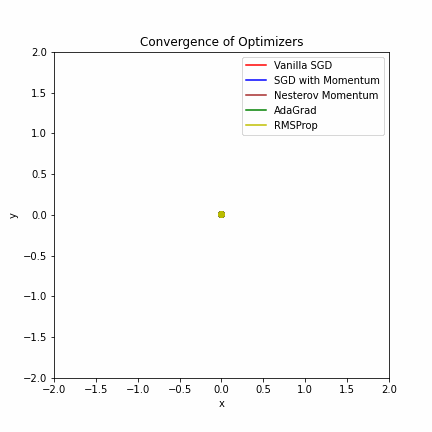

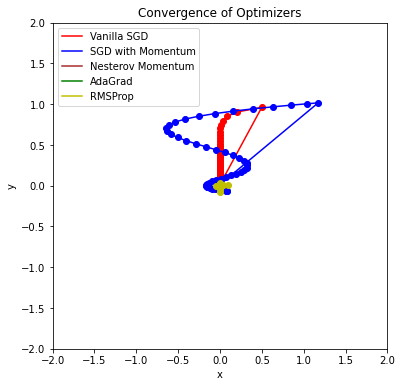

In [ ]:
from matplotlib.animation import FuncAnimation

# Defining the figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Convergence of Optimizers')

# Defining the plot objects for optimization algos implemented (Vanilla SGD, SGD with momentum, Nesterov Momentum, AdaGrad and RMSProp)
vanilla_sgd_line, = ax.plot([], [], 'r', label='Vanilla SGD')
momentum_line, = ax.plot([], [], 'b', label='SGD with Momentum')
nesterov_momentum_line, = ax.plot([], [], 'brown', label='Nesterov Momentum')
adagrad_line, = ax.plot([], [], 'g', label='AdaGrad')
rmsprop_line, = ax.plot([], [], 'y', label='RMSProp')
ax.legend()

# Defining the update function for the animation
def update(i):
    # Update the plot objects with the new points for all the optimization algorithms implemented
    vanilla_sgd_line.set_data(np.array(vanilla_sgd_points[:i+1]).T)
    momentum_line.set_data(np.array(momentum_points[:i+1]).T)
    nesterov_momentum_line.set_data(np.array(nesterov_momentum_points[:i+1]).T)
    adagrad_line.set_data(np.array(adagrad_points[:i+1]).T)
    rmsprop_line.set_data(np.array(rms_points[:i+1]).T)

    vanilla_sgd_line.set_marker('o')
    momentum_line.set_marker('o')
    nesterov_momentum_line.set_marker('o')
    adagrad_line.set_marker('o')
    rmsprop_line.set_marker('o')
    return vanilla_sgd_line, momentum_line, nesterov_momentum_line, adagrad_line, rmsprop_line

# Creating the animation object
ani = FuncAnimation(fig, update, frames=num_iterations+1, interval=100, blit=True)

# Save the animation as a GIF file
ani.save('convergence.gif', writer='imagemagick')


import imageio
from IPython.display import display, Image
from io import BytesIO

# Load the GIF
gif_path = "/content/convergence.gif"
gif = imageio.mimread(gif_path)

# Create an in-memory file object
gif_file = BytesIO()
imageio.mimsave(gif_file, gif, 'GIF')

# Displaying the GIF using IPython.display
display(Image(data=gif_file.getvalue(), format='gif'))
